In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("derrom/")
sys.path.append("ELPH/")
sys.path.append("utils/")

import derrom
import ivp_integrator
import PHELPH


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
kmax = 2.5
n_kmax = 100

tmax = 10000
n_tmax = 1001
t_vec = np.linspace(0,tmax,n_tmax)

system = PHELPH.PHELPH(kmax=kmax, n_kmax=n_kmax)

v = 'v2'
system.g_photon = 0.02
system.tau_photon = 200
system.E_photon = 0.0175
system.linewidth = 0.005

# v = 'v3'
# system.g_photon = 0.01
# system.tau_photon = 500
# system.E_photon = 0.0175
# system.linewidth = 0.005

system.setup_laser()

In [9]:
I_trajectories = derrom.utils.load_trajectories(filename='../PHELPH_I_kmax2.5_nkmax_100_n1000_'+v+'.npz')
el_trajectories = derrom.utils.load_trajectories(filename='../PHELPH_el_kmax2.5_nkmax_100_n1000_'+v+'.npz')
el_scattering = derrom.utils.load_trajectories(filename='../PHELPH_el_scat_kmax2.5_nkmax_100_n1000_'+v+'.npz')

n_sample = 1

I_trajectories = I_trajectories[::n_sample]
el_trajectories = el_trajectories[::n_sample]
el_scattering = el_scattering[::n_sample]

n_trajectories = len(el_trajectories)
n_kmax = el_trajectories[0].shape[1]

trajectories = [ np.concatenate([el_trajectories[k],I_trajectories[k].reshape(-1,1)], axis=1) for k in range(n_trajectories) ]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


cutoff = int(n_trajectories*0.9)

train_I_trajectories = I_trajectories[:cutoff]
train_el_trajectories = el_trajectories[:cutoff]
train_el_scattering = el_scattering[:cutoff]

test_I_trajectories = I_trajectories[cutoff:]
test_el_trajectories = el_trajectories[cutoff:]
test_el_scattering = el_scattering[cutoff:]

test_trajectories = trajectories[cutoff:]


1000 loaded with n_kmax = 100


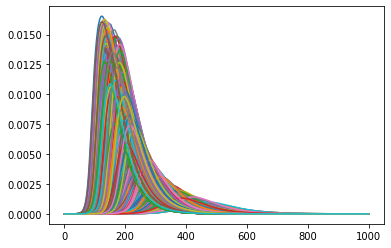

In [5]:
for I in I_trajectories:
    plt.plot(I)
    
plt.show()

0.008485126029804786
0.0036257845944320834


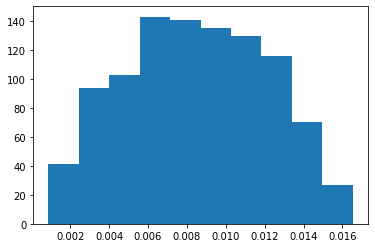

2051.52


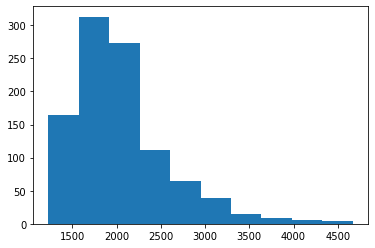

626.1100332704403


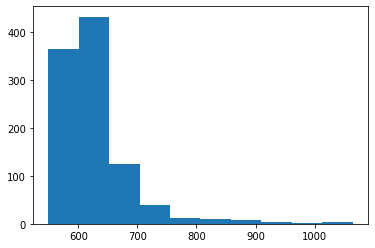

In [6]:
I_max = [I.max() for I in I_trajectories]
print(np.mean(I_max))
print(np.std(I_max))
plt.hist(I_max)
plt.show()

I_max_pos = [np.argmax(I)*10. for I in I_trajectories]
print(np.mean(I_max_pos))
plt.hist(I_max_pos)
plt.show()

I_width = []
for I in I_trajectories:
    p = I/np.sum(I)
    mu = np.sum(t_vec*p)
    std = np.sqrt(np.sum(p*np.square(t_vec-mu)))
    I_width.append(std)
    
print(np.mean(I_width))
plt.hist(I_width)
plt.show()

In [10]:
dim_reducer = derrom.dim_reducers.SVD()

scaler = derrom.scalers.standardize_scaler(1.0)
transformer = derrom.transformers.ELM_features(ELM_nodes=1000)
optimizer = derrom.optimizers.ridge(alpha=10.**4)

# scaler = derrom.scalers.normalize_scaler(0.1)
# transformer = derrom.transformers.polynomial_features(order=2)
# optimizer = derrom.optimizers.ridge(alpha=10.**-2.)

el_scat_model = derrom.derrom(rdim=10, DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)


def derivs(y):
    
    el_hist = y[:,:-1]
    el_state = y[-1,:-1]
    I = y[-1,-1]
    
    df = el_scat_model.predict(el_hist)
    df += -system.g_photon * I * system.lineshape_vec * (2.*el_state - 1.0)
    
    
    dI = -I/system.tau_photon + I * np.sum(system.I_gain_helper_vec * (2.*el_state - 1.0))
    dI += 1e-9
    
    return np.concatenate((df[0],[dI]))


integrator = ivp_integrator.PHELPH_ivp_integrator(el_scat_model, derivs, dt=5.0, dt_out=10., method='Heun')

In [11]:
el_scat_model.fit(train_el_trajectories, train_el_scattering)

el_scat_model.print_status()

full_hist:  True
intercept:  True
standardize:  True
rdim:  10
DE_l:  2
weights shape:  (1021, 100)


In [13]:
derrom.utils.save_model(el_scat_model,'../el_scat_model_self_con_I.obj')

utils/fermi_fit.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  return 1./(np.exp((E-mu)/(self.kB*T)) + 1)
utils/fermi_fit.py:25: RuntimeWarning: overflow encountered in exp
  return 1./(np.exp((E-mu)/(self.kB*T)) + 1)
utils/fermi_fit.py:118: RuntimeWarning: invalid value encountered in double_scalars
  mstep = (deltaE*dDdT-deltaD*dEdT)/Jacobi_Det
utils/fermi_fit.py:119: RuntimeWarning: invalid value encountered in double_scalars
  Tstep = (deltaD*dEdmu-deltaE*dDdmu)/Jacobi_Det


rms error: 0.00829111533964077
max error: 0.0381667724099084
I_max error: 8.846064469778155e-05
I_max_pos error: -10.0
I_area error: 0.03784922174153116


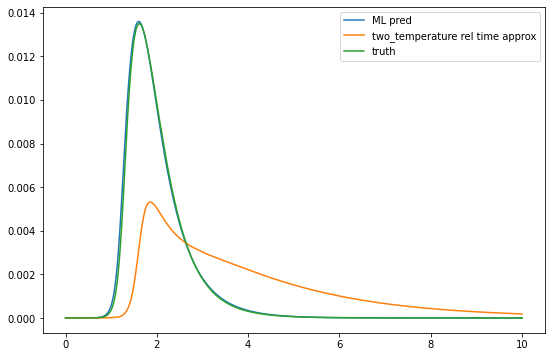

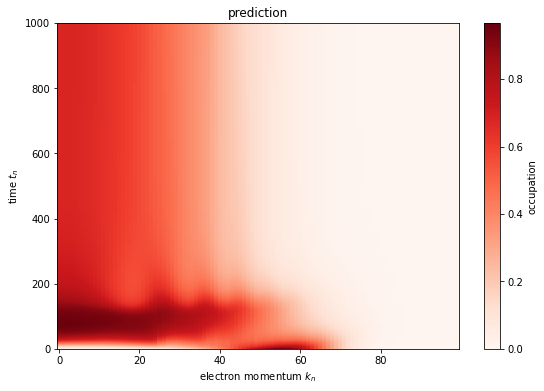

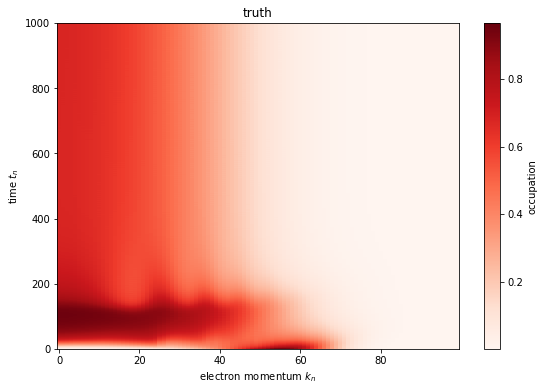

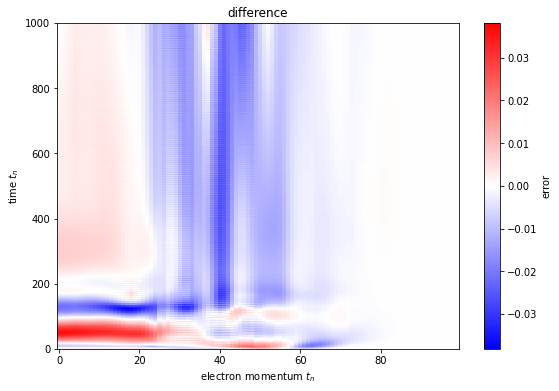

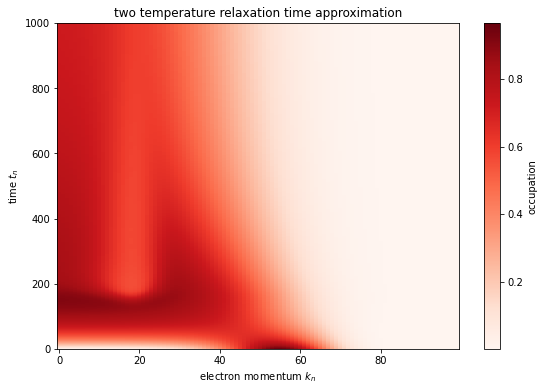

In [12]:
ind = 3

test_el_trajectory = test_el_trajectories[ind]
test_I_trajectory = test_I_trajectories[ind]
test_trajectory = test_trajectories[ind]

inits = test_trajectory[:1]

pred = integrator.integrate(test_trajectory,test_el_trajectory.shape[0])


# rel_time_approx = system.rel_time_approx(inits.flatten(),tmax=tmax, n_tmax=n_tmax,tau_rel=500)


ttrt_inits = np.concatenate([test_trajectory[0,:system.n_kmax],[system.T_cryo],[test_trajectory[0,-1]]])
ttrt_approx = system.two_temperature_rel_time_approx(ttrt_inits,tmax=tmax, n_tmax=n_tmax,tau_rel=500,tau_Tp=4000)


print('rms error:', integrator.get_error(test_trajectory,pred, norm='rms'))
print('max error:', integrator.get_error(test_trajectory,pred, norm='max'))
print('I_max error:', integrator.get_error(test_trajectory,pred, norm='I_max'))
print('I_max_pos error:', integrator.get_error(test_trajectory,pred, norm='I_max_pos'))
print('I_area error:', integrator.get_error(test_trajectory,pred, norm='I_area'))


plt.plot(t_vec/1000,pred[:,-1],label='ML pred')
# plt.plot(t_vec/1000,rel_time_approx[:,-1],label='rel time approx')
plt.plot(t_vec/1000,ttrt_approx[:,-1],label='two_temperature rel time approx')
plt.plot(t_vec/1000,test_I_trajectory,label='truth')
plt.legend()
plt.show()


derrom.utils.plot_trajectory(pred[:,:-1],title='prediction')

derrom.utils.plot_trajectory(test_el_trajectory,title='truth')

derrom.utils.plot_difference(truth=test_el_trajectory,test=pred[:,:-1])

# derrom.utils.plot_trajectory(rel_time_approx[:,:-1],title='relaxation time approximation')

derrom.utils.plot_trajectory(ttrt_approx[:,:-2],title='two temperature relaxation time approximation')


# plt.plot(system.E_el_vec,test_el_trajectory[-1],label='truth')
# plt.plot(system.E_el_vec,pred[-1,:-1],label='ML')
# plt.plot(system.E_el_vec,rel_time_approx[-1,:-1],label='rta')
# plt.plot(system.E_el_vec,ttrt_approx[-1,:-2],label='ttrta')
# plt.legend()
# plt.show()


In [37]:
ind = 3

test_el_trajectory = test_el_trajectories[ind]
test_I_trajectory = test_I_trajectories[ind]
test_trajectory = test_trajectories[ind]


ttrt_inits = np.concatenate([test_trajectory[0,:system.n_kmax],[system.T_cryo],[test_trajectory[0,-1]]])
ttrt_approx = system.two_temperature_rel_time_approx(ttrt_inits,tmax=tmax, n_tmax=n_tmax,tau_rel=500,tau_Tp=4000)

utils/fermi_fit.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  return 1./(np.exp((E-mu)/(self.kB*T)) + 1)
utils/fermi_fit.py:25: RuntimeWarning: overflow encountered in exp
  return 1./(np.exp((E-mu)/(self.kB*T)) + 1)
utils/fermi_fit.py:118: RuntimeWarning: invalid value encountered in double_scalars
  mstep = (deltaE*dDdT-deltaD*dEdT)/Jacobi_Det
utils/fermi_fit.py:119: RuntimeWarning: invalid value encountered in double_scalars
  Tstep = (deltaD*dEdmu-deltaE*dDdmu)/Jacobi_Det


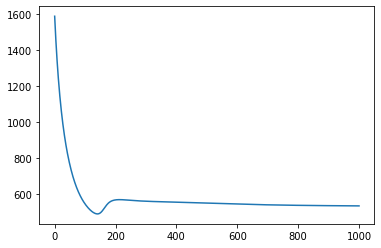

In [20]:
sys.path.append("../utils/")
import fermi_fit
fermi_fitter = fermi_fit.fermi_fit(system.DOS_vec, system.E_el_vec, system.kB)

Te_vec = []
mus = []
Steps = []

ind_start = 0

for k in range(ttrt_approx[ind_start:,:-2].shape[0]):
    mu,Temp,steps = fermi_fitter.fit_mu_T(ttrt_approx[ind_start:,:-2][k], 0.1, 300, False)
    mus.append(mu)
    Te_vec.append(Temp)
    Steps.append(steps)

Te_vec = np.asarray(Te_vec)
    
plt.plot(Te_vec)
plt.show()

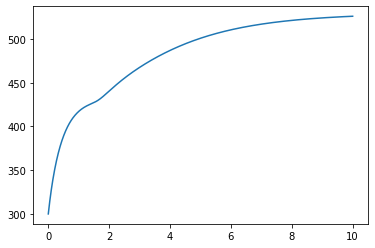

In [10]:
plt.plot(t_vec/1000,ttrt_approx[:,-2],label='two_temperature rel time approx')
plt.show()

7.127778816532312e-05


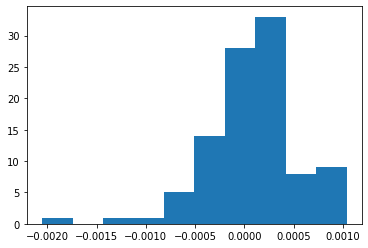

In [11]:
mean, mscores = integrator.score_multiple_trajectories(test_trajectories, norm='I_max')

print(mean)

plt.hist(mscores,bins=10)
plt.show()

In [9]:
dim_reducer = derrom.dim_reducers.SVD()

scaler = derrom.scalers.standardize_scaler(1.0)
transformer = derrom.transformers.ELM_features(ELM_nodes=1000)
optimizer = derrom.optimizers.ridge(alpha=10.**4)

# scaler = derrom.scalers.normalize_scaler(0.1)
# transformer = derrom.transformers.polynomial_features(order=2)
# optimizer = derrom.optimizers.ridge(alpha=10.**-2.)

el_scat_model = derrom.derrom(rdim=10, DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)

integrator = ivp_integrator.PHELPH_ivp_integrator(el_scat_model, derivs, dt=5.0, dt_out=10., method='Heun')

scores = derrom.utils.get_KFold_CV_scores(integrator, trajectories, el_scattering, folds=10, seed=817,
                                          norms=['rms','max','I_max','I_max_pos','I_area'],
                                          train_kwargs={})

print('rms error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )
print('I_max error: ', str(np.mean(scores[2])) + ' +- ' + str(np.std(scores[2])) )
print('I_max_pos error: ', str(np.mean(scores[3])) + ' +- ' + str(np.std(scores[3])) )
print('I_area error: ', str(np.mean(scores[4])) + ' +- ' + str(np.std(scores[4])) )

rms error:  0.011004426092995755 +- 0.009066852439170861
max error:  0.05116169264128608 +- 0.03986410357458937
I_max error:  -1.2300147298473955e-06 +- 0.00047528465836057626
I_max_pos error:  34.12 +- 509.60222291508893
I_area error:  0.018371068277802983 +- 0.0574813390760821


0.008485126029804786
0.9443071608635486
rms error:  0.011004426092995755 +- 0.009066852439170861
max error:  0.05116169264128608 +- 0.03986410357458937
I_max error:  0.038793661697717835 +- 0.05601385962814166
I_max_pos error:  147.64 +- 509.60222291508893
I_area error:  0.04273424725366393 +- 0.06087144253308071


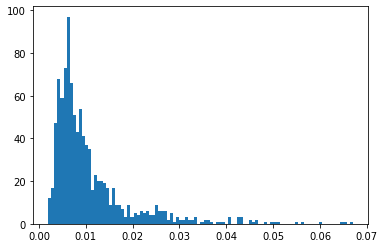

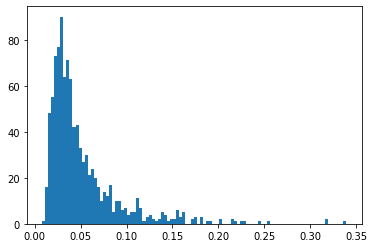

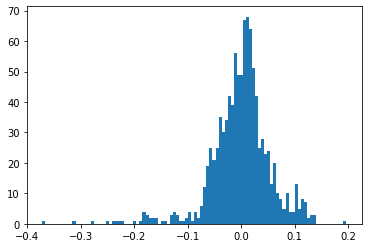

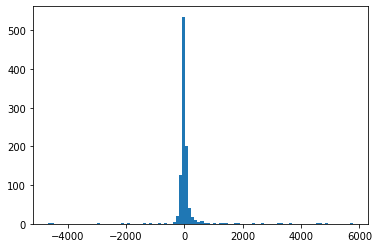

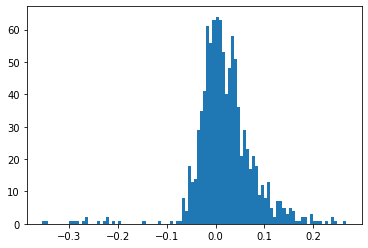

In [10]:
mean_I_max = np.mean([I.max() for I in I_trajectories])
print(mean_I_max)
mean_I_area = np.mean([np.sum(I) for I in I_trajectories])
print(mean_I_area)


print('rms error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )
print('I_max error: ', str(np.mean(np.abs(scores[2]))/mean_I_max) + ' +- ' + str(np.std(scores[2])/mean_I_max) )
print('I_max_pos error: ', str(np.mean(np.abs(scores[3]))) + ' +- ' + str(np.std(scores[3])) )
print('I_area error: ', str(np.mean(np.abs(scores[4]))/mean_I_area) + ' +- ' + str(np.std(scores[4])/mean_I_area) )

plt.hist(scores[0],bins=len(scores[0])//10)
plt.show()

plt.hist(scores[1],bins=len(scores[1])//10)
plt.show()

plt.hist(scores[2]/mean_I_max,bins=len(scores[2])//10)
plt.show()

plt.hist(np.array(scores[3]),bins=len(scores[3])//10)
plt.show()

plt.hist(scores[4]/mean_I_area,bins=len(scores[4])//10)
plt.show()

In [11]:
np.savetxt('../PHELPH_ML_scores', scores)

In [ ]:
masked_weights = np.ma.masked_values(el_scat_model.w,0.0)
plt.imshow(np.abs(masked_weights), aspect='auto', interpolation='none', origin='lower',cmap='Greens')
plt.colorbar()
plt.title('weights')
plt.ylim(0,40)
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(el_scat_model.w))))
plt.title('sorted weights')
plt.show()

plt.hist(np.ravel(el_scat_model.w), bins=200)
plt.title('weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

In [ ]:
plt.semilogy(dim_reducer.S[:20], 'o')
plt.show()

In [ ]:
rel_time_approx = system.rel_time_approx(test_trajectory[0].flatten(),tmax=tmax, n_tmax=n_tmax,tau_rel=1000)


print('rms error:', integrator.get_error(test_trajectory,rel_time_approx, norm='rms'))
print('max error:', integrator.get_error(test_trajectory,rel_time_approx, norm='max'))
print('I_max error:', integrator.get_error(test_trajectory,rel_time_approx, norm='I_max'))
print('I_max_pos error:', integrator.get_error(test_trajectory,rel_time_approx, norm='I_max_pos'))
print('I_area error:', integrator.get_error(test_trajectory,rel_time_approx, norm='I_area'))


In [ ]:
rta_scores = []

for trajectory in trajectories:
    rel_time_approx = system.rel_time_approx(trajectory[0].flatten(),tmax=tmax, n_tmax=n_tmax,tau_rel=1000)
    
    el_rms = integrator.get_error(trajectory,rel_time_approx, norm='rms')
    el_max = integrator.get_error(trajectory,rel_time_approx, norm='max')
    I_max = integrator.get_error(trajectory,rel_time_approx, norm='I_max')
    I_max_pos = integrator.get_error(trajectory,rel_time_approx, norm='I_max_pos')
    I_area = integrator.get_error(trajectory,rel_time_approx, norm='I_area')
    
    rta_scores.append([el_rms,el_max,I_max,I_max_pos,I_area])
    
    
    

In [ ]:
ttrta_scores = []

for trajectory in trajectories:
    
    ttrt_inits = np.concatenate([trajectory[0,:system.n_kmax],[system.T_cryo],[trajectory[0,-1]]])
    ttrt_approx = system.two_temperature_rel_time_approx(ttrt_inits,tmax=tmax, n_tmax=n_tmax,tau_rel=500,tau_Tp=4000)
    
    ttrt_approx = np.concatenate([ttrt_approx[:,:-2],ttrt_approx[:,-1:]],axis=1)
    
    el_rms = integrator.get_error(trajectory,ttrt_approx, norm='rms')
    el_max = integrator.get_error(trajectory,ttrt_approx, norm='max')
    I_max = integrator.get_error(trajectory,ttrt_approx, norm='I_max')
    I_max_pos = integrator.get_error(trajectory,ttrt_approx, norm='I_max_pos')
    I_area = integrator.get_error(trajectory,ttrt_approx, norm='I_area')
    
    ttrta_scores.append([el_rms,el_max,I_max,I_max_pos,I_area])

In [ ]:
ttrta_scores = np.array(ttrta_scores).T
print(ttrta_scores.shape)

In [ ]:
plt.hist(ttrta_scores[0], bins=100)
plt.hist(scores[0],bins=len(scores[0])//10)
plt.show()

plt.hist(ttrta_scores[1], bins=100)
plt.hist(scores[1],bins=len(scores[1])//10)
plt.show()

plt.hist(ttrta_scores[2]/mean_I_max, bins=100)
plt.hist(scores[2]/mean_I_max,bins=len(scores[2])//10)
plt.show()

plt.hist(ttrta_scores[3]*5.0, bins=100)
plt.hist(np.array(scores[3])*5.0,bins=len(scores[3])//10, range=(-500,500))
plt.show()

plt.hist(ttrta_scores[4]/mean_I_area, bins=100)
plt.hist(scores[4]/mean_I_area,bins=len(scores[4])//10)
plt.show()